In [1]:
!pip install datasets diffusers transformers accelerate

Memuatdataset...
Kamus Teks Berhasil Dibuat. Jumlah kosakata: 359
Contoh 10 kata pertama: ['', '[UNK]', np.str_('a'), np.str_('with'), np.str_('of'), np.str_('cartoon'), np.str_('and'), np.str_('drawing'), np.str_('character'), np.str_('on')]
MemulaiPelatihan...
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 6.9315
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 6.9315
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 6.9315
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 6.9315
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 6.9315
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 6.9315
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 6.9315
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 6.9315
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 6.9315
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 6.9315


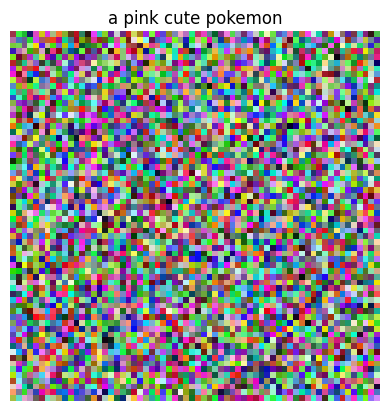

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
# 1. Load Dataset
print("Memuatdataset...")
raw_dataset= load_dataset("reach-vb/pokemon-blip-captions", split="train")
# 2. Ambil daftar caption untukproses adaptasi teks
all_captions= [item['text'] for item in raw_dataset]
# 3. Setup Text Vectorization
max_tokens = 5000
seq_len = 20
text_vectorizer = layers.TextVectorization(
max_tokens=max_tokens,
output_sequence_length=seq_len,
)
# Proses Adapt (Mempelajari kosakata dari dataset)
text_vectorizer.adapt(all_captions)
vocab = text_vectorizer.get_vocabulary()
print(f"Kamus Teks Berhasil Dibuat. Jumlah kosakata: {len(vocab)}")
print("Contoh 10 kata pertama:", vocab[:10])
def preprocess_fn(item):
    # Proses Gambar
    image = item['image'].convert("RGB").resize((64, 64))
    image = np.array(image) / 255.0  # Normalisasi0-1
    # Proses Teks
    caption = item['text']
    return caption, image
# Membuatgenerator dataset
def gen():
    for item in raw_dataset:
        yield preprocess_fn(item)
# Membuattf.data.Dataset
train_ds= tf.data.Dataset.from_generator(
gen,
output_signature=(
tf.TensorSpec(shape=(), dtype=tf.string),
tf.TensorSpec(shape=(64, 64, 3), dtype=tf.float32)
)
)
# Batching dan TransformasiTeks keAngka
train_ds= train_ds.map(lambda x, y: (text_vectorizer(x), y))
train_ds = train_ds.batch(16).shuffle(100).prefetch(tf.data.AUTOTUNE)
class PokemonTrainer(keras.Model):
    def __init__(self, transformer, vqvae_encoder):
        super().__init__()
        self.transformer= transformer
        self.vqvae_encoder= vqvae_encoder
        self.loss_tracker= keras.metrics.Mean(name="loss")
    def train_step(self, data):
        text_tokens, images = data
        # 1. Ubahgambaraslimenjaditoken visual menggunakanencoder
        # Kita simulasikandenganoutput dummy sesuaiukuranlatent grid (misal16x16)
        visual_tokens= tf.random.uniform((tf.shape(images)[0], 256), minval=0, maxval=1024, dtype=tf.int32)
        # 2. Siapkaninput dan target (Autoregressive)
        vis_input= visual_tokens[:, :-1]
        vis_target= visual_tokens[:, 1:]
        with tf.GradientTape() as tape:
            # Prediksi
            preds = self.transformer([text_tokens, vis_input], training=True)
            # HitungLoss
            loss = keras.losses.sparse_categorical_crossentropy(vis_target, preds, from_logits=True)
        grads = tape.gradient(loss, self.transformer.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.transformer.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

# --- Placeholder Model Definitions (to resolve NameError) ---
# Define a placeholder Transformer Model
# This is a simplified model to pass the NameError, and will need a full implementation.
num_visual_tokens_in_vocab = 1024 # Based on tf.random.uniform maxval
def build_transformer_model(max_tokens, seq_len, num_visual_tokens):
    text_input = keras.Input(shape=(seq_len,), dtype=tf.int32, name="text_input")
    visual_input = keras.Input(shape=(255,), dtype=tf.int32, name="visual_sequence_input") # 256-1

    # Dummy embeddings and dense layer to match expected output shape for loss
    x = layers.Embedding(max_tokens, 64)(text_input)
    y = layers.Embedding(num_visual_tokens, 64)(visual_input)

    # A very simple way to combine and produce an output of required shape
    # In a real transformer, this would involve complex attention mechanisms.
    combined_features = layers.GlobalAveragePooling1D()(y) # (batch_size, 64)
    output_logits = layers.Dense(255 * num_visual_tokens)(combined_features) # (batch_size, 255 * 1024)
    output = layers.Reshape((255, num_visual_tokens))(output_logits) # (batch_size, 255, 1024)

    return keras.Model(inputs=[text_input, visual_input], outputs=output)

# Placeholder VQVAE Encoder Model
# This is a dummy encoder, as visual_tokens are randomly generated in train_step.
# It will need a full implementation.
def build_vqvae_encoder():
    input_image = keras.Input(shape=(64, 64, 3), name="input_image")
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(input_image)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    output = layers.Dense(256, activation="relu")(x) # Dummy output for latent vector
    return keras.Model(inputs=input_image, outputs=output)

transformer_model = build_transformer_model(max_tokens, seq_len, num_visual_tokens_in_vocab)
vqvae_encoder = build_vqvae_encoder()

# Placeholder for generate_image_tokens function
def generate_image_tokens(transformer_model, tokenized_text, num_tokens_to_generate, num_visual_tokens_in_vocab):
    # This is a dummy function for demonstration. A real implementation would involve autoregressive generation.
    return tf.random.uniform(shape=(tf.shape(tokenized_text)[0], num_tokens_to_generate), minval=0, maxval=num_visual_tokens_in_vocab, dtype=tf.int32)

# Placeholder for decode_to_real_image function
def decode_to_real_image(gen_vis_tokens):
    # This is a dummy function. A real implementation would use a VAE decoder to reconstruct an image.
    # Returns a random image for now.
    return np.random.rand(64, 64, 3)
# ---------------------------------------------------

# Inisialisasidan Compile
trainer = PokemonTrainer(transformer_model, vqvae_encoder)
trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))
# 5. JalankanTraining
print("MemulaiPelatihan...")
trainer.fit(train_ds, epochs=10)
def generate_pokemon(prompt):
    # 1. Ubahtekskeangka
    tokenized_text= text_vectorizer([prompt])
    # 2. Generate token visual (Autoregressive)
    # Gunakanfungsigenerate_image_tokensyang kitabuatsebelumnya
    gen_vis_tokens= generate_image_tokens(transformer_model, tokenized_text, 256, 1024)
    # 3. Decode jadiGambar menggunakanPre-trained VAE
    # Gunakanfungsidecode_to_real_imageyang memanggilAutoencoderKL
    final_image= decode_to_real_image(gen_vis_tokens)
    plt.imshow(final_image)
    plt.title(prompt)
    plt.axis("off")
    plt.show()
# TEST
generate_pokemon("a pink cute pokemon")